# Разработка модели предсказания стоимости автомобиля на вторичном рынке.

Цель проекта - разработка модели предварительной оценки стоимости автомобиля на вторичном рынке.

**Задачи, которые необходимо выполнить для достижения цели:**
- загрузка необходимых библиотек и инструментов;
- загрузка и изучение предоставленных датафреймов - тренировочного, на основе которого будет разрабатываться модель, и тестового;
- предварительная обработка данных: 
    - проверка на дубликаты, 
    - заполнение выявленных пропусков в данных, подобранным для каждого столбца способом;
- на основе предварительного анализа создадим столбцы с новыми признаками;
- закодируем категориальные признаки;
- изучим корреляцию между признаками;
- проведём отбор признаков для обучения модели;
- выберем модели обучения;
- с помощью кроссвалидации на тренеровочном датафрейме подберём гиперпараметры для выбранных моделей;
- обучим модели и выберем лучшую модель по метрике MAPE;
- получим предсказание модели на предоставленном тестовом датафрейме.

### Загружаем необходимые библиотеки и инструменты

In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.utils import shuffle
import datetime
import category_encoders as ce
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

### Загружаем тренировочный и тестовый датасеты

In [2]:
try:
    data_train = pd.read_csv('/copy-of-used-cars-price-prediction-ds18/train.csv')
    data_test = pd.read_csv('/copy-of-used-cars-price-prediction-ds18/test.csv')
except:
    data_train = pd.read_csv('/auto_prise/train.csv')
    data_test = pd.read_csv('/auto_prise/test.csv')

### Исследуем тренировочный датасет

In [3]:
data_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


In [4]:
data_train.shape

(440236, 15)

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [6]:
data_train.describe()

,year,condition,odometer,sellingprice
count,440236.000000,430831.000000,440167.000000,440236.000000
mean,2010.040101,3.425077,68344.421604,13592.209588
std,3.977945,0.949973,53542.203908,9751.479098
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28258.000000,6900.000000
50%,2012.000000,3.600000,52098.000000,12100.000000
75%,2013.000000,4.200000,99272.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


In [7]:
data_train.duplicated().sum()

0

In [8]:
data_train.isnull().sum()

year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

**По первичному анализу видно, что явных дубликатов в датасете нет, но есть пропуски в 9-и столбцах. Изучим все столбцы по отдельности и найдем способ заполнения пропусков для каждого столбца.**

**Нашим целевым признаком является столбец `sellingprice` - стоимость продажи. Изучим его.**

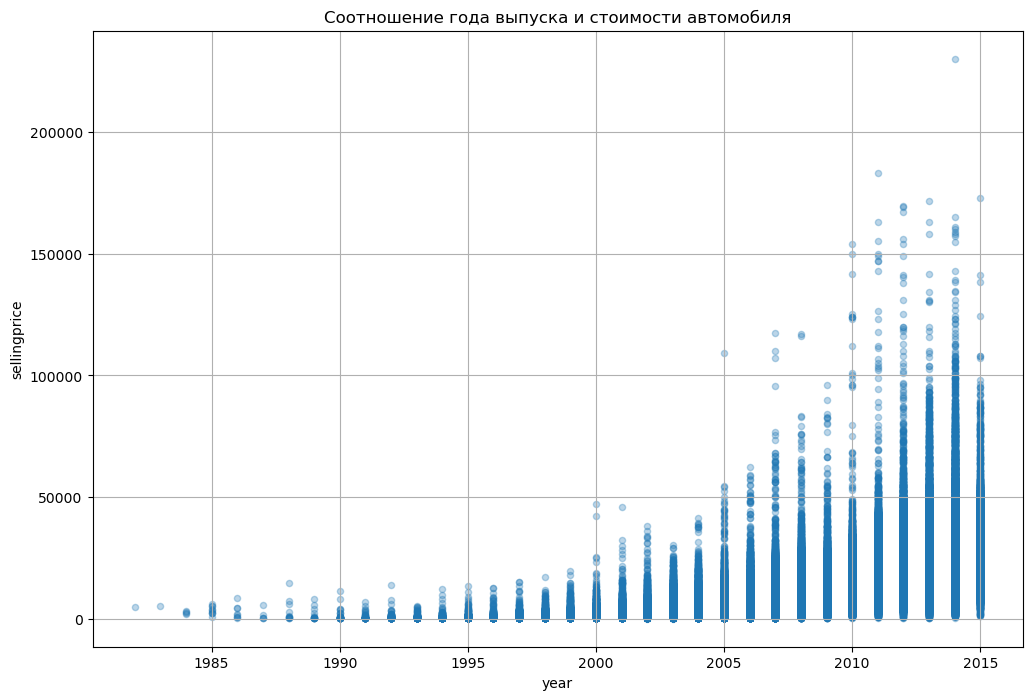

In [9]:
data_train.plot(x='year', y='sellingprice', kind='scatter', alpha=0.3, grid=True, figsize=(12, 8), 
          title='Соотношение года выпуска и стоимости автомобиля');

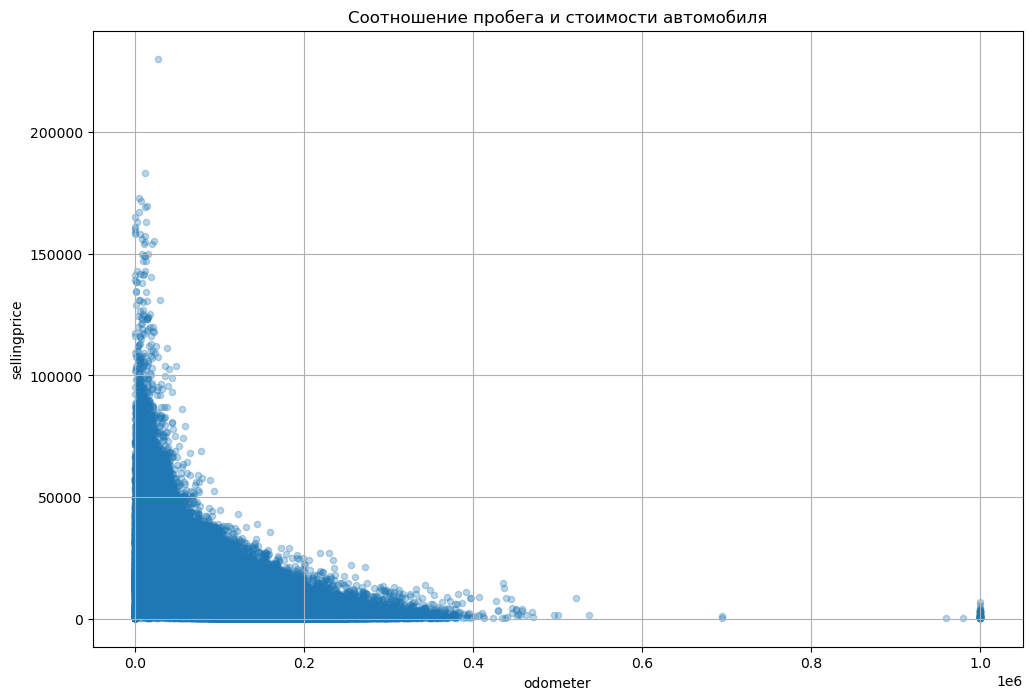

In [10]:
data_train.plot(x='odometer', y='sellingprice', kind='scatter', alpha=0.3, grid=True, figsize=(12, 8), 
          title='Соотношение пробега и стоимости автомобиля');

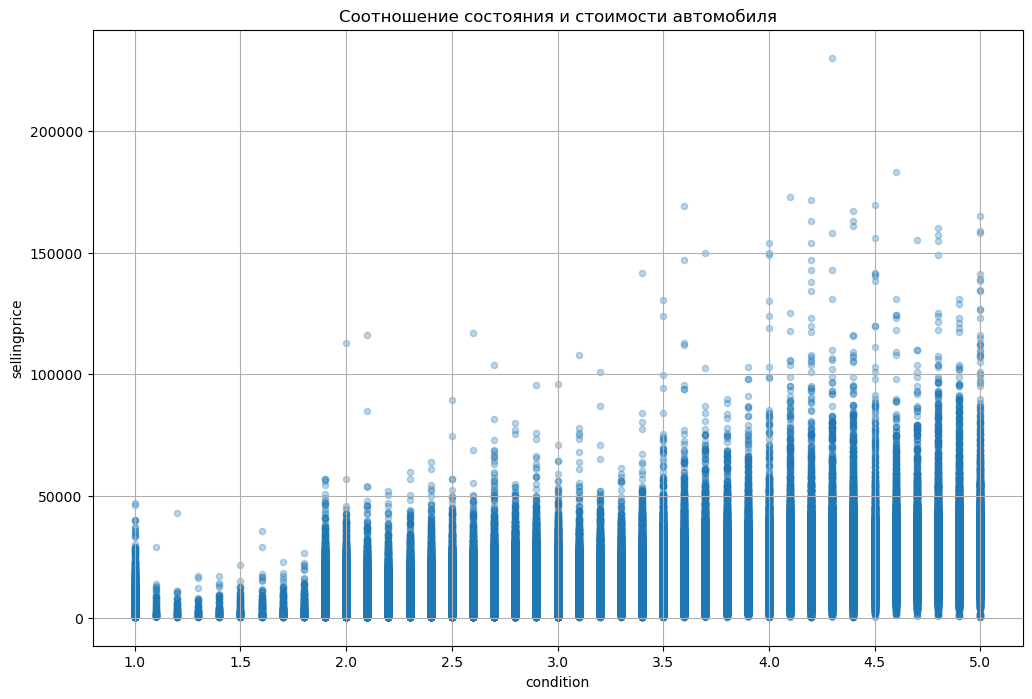

In [11]:
data_train.plot(x='condition', y='sellingprice', kind='scatter', alpha=0.3, grid=True, figsize=(12, 8), 
          title='Соотношение состояния и стоимости автомобиля');

In [12]:
data_train.corr(numeric_only=True)

,year,condition,odometer,sellingprice
year,1.000000,0.553403,-0.774498,0.586847
condition,0.553403,1.000000,-0.540544,0.538906
odometer,-0.774498,-0.540544,1.000000,-0.583044
sellingprice,0.586847,0.538906,-0.583044,1.000000


**Из графиков и таблицы корреляции признаков видно, что на стоимость автомобиля влияет состояние - чем выше значение, тем выше стоимость, пробег - чем ниже, тем выше стоимость, год выпуска - чем моложе автомобиль, тем выше стоимость и меньше пробег.**

### Проводим исследование и предобработку каждого столбца. Создаём столбцы с новыми признаками.

**Переведём столбец `saledate` с датой продажи к типу .daytime и извлечём из него месяц и год, создадим два новых столбца `sale_year` и `sale_month`**

In [13]:
data_train['saledate'] = data_train['saledate'].apply(lambda x: datetime.datetime.strptime(x[:-15], "%a %b %d %Y %H:%M:%S"))

In [14]:
data_train['sale_year'] = pd.DatetimeIndex(data_train['saledate']).year
data_train['sale_year'].unique()

array([2015, 2014], dtype=int64)

In [15]:
data_train['sale_month'] = pd.DatetimeIndex(data_train['saledate']).month
data_train['sale_month'].unique()

array([ 6,  2,  5,  1, 12,  3,  4,  7], dtype=int64)

In [16]:
data_train.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,sale_year,sale_month
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,2015-06-02 02:30:00,2015,6
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,2015-02-25 02:00:00,2015,2
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,2015-06-10 02:30:00,2015,6
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,2015-06-17 03:00:00,2015,6
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,2015-02-03 04:00:00,2015,2


**Изучим столбец `make` - производитель**.

In [17]:
data_train['make'].unique()

array(['Ford', 'Nissan', 'HUMMER', 'Lincoln', 'pontiac', 'Hyundai', nan,
       'Buick', 'Chevrolet', 'Honda', 'Acura', 'Cadillac', 'GMC', 'Saab',
       'Dodge', 'Mercedes-Benz', 'Toyota', 'Volkswagen', 'BMW',
       'Infiniti', 'Chrysler', 'Kia', 'Jaguar', 'Subaru', 'Jeep', 'Lexus',
       'mercedes', 'Scion', 'FIAT', 'Suzuki', 'Mazda', 'Volvo', 'Audi',
       'MINI', 'Isuzu', 'Mitsubishi', 'smart', 'Pontiac', 'Porsche',
       'subaru', 'ford', 'Land Rover', 'chrysler', 'Saturn', 'mazda',
       'dodge', 'Ram', 'Oldsmobile', 'hyundai', 'Mercury', 'Bentley',
       'toyota', 'lincoln', 'Fisker', 'nissan', 'chevrolet', 'honda',
       'porsche', 'mitsubishi', 'lexus', 'bmw', 'Maserati', 'acura',
       'jeep', 'mercury', 'Tesla', 'landrover', 'vw', 'cadillac', 'buick',
       'gmc truck', 'land rover', 'volkswagen', 'Rolls-Royce', 'audi',
       'Ferrari', 'suzuki', 'Plymouth', 'oldsmobile', 'Lamborghini',
       'gmc', 'Geo', 'ford truck', 'Aston Martin', 'plymouth', 'Daewoo',
      

In [18]:
data_train['make'].nunique()

92

In [19]:
data_train = data_train.replace({ 'bmw': 'BMW',
                                 'smart': 'Smart',
                                 'oldsmobile': 'Oldsmobile',
                                 'ford': 'Ford',
                                 'ford truck': 'Ford',
                                 'chrysler': 'Chrysler',
                                 'mazda': 'Mazda',
                                 'mazda tk': 'Mazda',
                                 'dodge tk': 'Dodge',
                                 'dodge': 'Dodge',
                                 'hyundai': 'Hyundai',
                                 'pontiac': 'Pontiac',
                                 'subaru': 'Subaru',
                                 'toyota': 'Toyota',
                                 'lincoln': 'Lincoln',
                                 'nissan': 'Nissan',
                                 'chevrolet': 'Chevrolet',
                                 'honda': 'Honda',
                                 'porsche': 'Porsche',
                                 'mitsubishi': 'Mitsubishi',
                                 'lexus': 'Lexus',
                                 'acura': 'Acura',
                                 'jeep': 'Jeep',
                                 'mercury': 'Mercury',
                                 'landrover': 'Land Rover',
                                 'land rover': 'Land Rover',
                                 'vw': 'Volkswagen',
                                 'volkswagen': 'Volkswagen',
                                 'audi': 'Audi',
                                 'suzuki': 'Suzuki',
                                 'gmc': 'GMC',
                                 'gmc truck': 'GMC',
                                 'plymouth': 'Plymouth',
                                 'maserati': 'Maserati',
                                 'kia': 'Kia',
                                 'mercedes-b': 'Mercedes-Benz',
                                 'mercedes': 'Mercedes-Benz',
                                 'dot': 'Dot',
                                 'airstream': 'Airstream'
})

In [20]:
data_train['make'].unique()

array(['Ford', 'Nissan', 'HUMMER', 'Lincoln', 'Pontiac', 'Hyundai', nan,
       'Buick', 'Chevrolet', 'Honda', 'Acura', 'Cadillac', 'GMC', 'Saab',
       'Dodge', 'Mercedes-Benz', 'Toyota', 'Volkswagen', 'BMW',
       'Infiniti', 'Chrysler', 'Kia', 'Jaguar', 'Subaru', 'Jeep', 'Lexus',
       'Scion', 'FIAT', 'Suzuki', 'Mazda', 'Volvo', 'Audi', 'MINI',
       'Isuzu', 'Mitsubishi', 'Smart', 'Porsche', 'Land Rover', 'Saturn',
       'Ram', 'Oldsmobile', 'Mercury', 'Bentley', 'Fisker', 'Maserati',
       'Tesla', 'cadillac', 'buick', 'Rolls-Royce', 'Ferrari', 'Plymouth',
       'Lamborghini', 'Geo', 'Aston Martin', 'Daewoo', 'Dot', 'Airstream'],
      dtype=object)

In [21]:
data_train['make'].nunique()

56

In [22]:
data_train['make'].value_counts()

Ford             74070
Chevrolet        47818
Nissan           42866
Toyota           31711
Dodge            24295
Honda            21600
Hyundai          17187
BMW              16254
Kia              14325
Chrysler         13796
Mercedes-Benz    13408
Infiniti         12123
Jeep             12107
Volkswagen        9901
Lexus             9363
GMC               8368
Mazda             6704
Cadillac          5865
Acura             4679
Audi              4635
Lincoln           4541
Subaru            4019
Buick             4012
Pontiac           3596
Ram               3592
Mitsubishi        3413
Volvo             2958
MINI              2473
Saturn            2247
Mercury           1561
Land Rover        1476
Scion             1338
Jaguar            1100
Porsche           1094
Suzuki             846
FIAT               672
HUMMER             597
Saab               384
Smart              311
Oldsmobile         294
Isuzu              163
Maserati           112
cadillac            93
Bentley    

**Изучим столбец `model` - модель**.

In [23]:
data_train['model'].unique()

array(['Edge', 'Fusion', 'Sentra', 'H2', 'MKZ', 'g6', 'Escape', 'Elantra',
       'Freestyle', nan, 'Lucerne', 'Windstar', 'Silverado 1500',
       'Murano', 'Equinox', 'Accord', 'Civic', 'MDX', 'CTS', 'Taurus',
       'SRX', 'Yukon', '9-3', 'Explorer', 'F-150', 'Charger', 'Armada',
       'GL-Class', 'Avalon', 'Tahoe', 'Malibu', 'Passat', 'Camry', 'Flex',
       '3 Series', 'Q50', 'Altima', 'Mustang', '300', 'Sonata',
       'Envoy XL', 'Rogue', 'Accent', 'Maxima', 'Forte', 'XF', 'Outback',
       'Grand Caravan', 'E-Class', 'Cherokee', 'Impala', 'Optima',
       '5 Series', 'Expedition', 'IS 250', 'MKS', '200', 'Veloster',
       'Golf', 'RAV4', 'e300dt', 'Five Hundred', 'G Coupe',
       'Grand Cherokee', 'X-Type', 'G Convertible', 'Tacoma', 'xA',
       'G Sedan', 'TL', 'Liberty', 'Soul', '500L', 'Town and Country',
       'HHR', 'Wrangler', 'Reno', 'Suburban', 'PT Cruiser', 'GX 460',
       'Sienna', 'SL-Class', 'Envoy', 'Patriot', 'E-Series Van', 'Versa',
       'Aspen', 'M', 'Co

In [24]:
data_train['model'].nunique()

959

In [25]:
data_train['model'].value_counts()

Altima           15454
F-150            11408
Fusion           10244
Camry             9996
Escape            9419
                 ...  
Civic del Sol        1
Tempo                1
Regency              1
8 Series             1
g500                 1
Name: model, Length: 959, dtype: int64

В столбце `make` - производитель, обнаружено 8043 пропусков, а в столбце `model` - модель, обнаружено 8123 пропусков. Так как в VIN-номере каждого автомобиля зашифрована его марка, модель идругие характеристики, то заполнять пропуски будем следующим образом - будем сравнивать первые знаки VIN-номера автомобилей с пропусками в столбцах `make` и `model`, с VIN-номерами автомобилей, где марка и модель в соответствующих столбцах указаны, и соответствующими значениями заполним пропуски в этих столбцах.

In [26]:
def fill_missing_make_model(data):
    total_rows = len(data)
    filled_rows = 0
    
    with tqdm(total=total_rows) as pbar:
        for index, row in data.iterrows():
            vin = row['vin'][:4]
            make = row['make']
            model = row['model']

            if pd.isnull(make) or pd.isnull(model):
                mask = (data['vin'].str[:4] == vin) & (~pd.isnull(data['make'])) & (~pd.isnull(data['model']))
                matching_rows = data.loc[mask]

                if len(matching_rows) > 0:
                    data.loc[index, 'make'] = matching_rows.iloc[0]['make']
                    data.loc[index, 'model'] = matching_rows.iloc[0]['model']

            filled_rows += 1
            pbar.update(1)
    
    return data

In [27]:
data_train_filled = fill_missing_make_model(data_train)

100%|█████████████████████████████████████████████████████████████████████████| 440236/440236 [26:11<00:00, 280.14it/s]


In [28]:
data_train.isnull().sum()

year                0
make               91
model              91
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
sale_year           0
sale_month          0
dtype: int64

In [29]:
data_train['make'] = data_train['make'].fillna('unknown')

In [30]:
data_train['model'] = data_train['model'].fillna('unknown')

**В столбце `make` - производитель, обнаружено 8043 пропусков, а также неявные дубликаты. Привели название марок к единому виду. Пропуски заполнили по первым знакам столбца `vin` в строках с пропусками, взятыми значениями из заполненных строк. Оставшиеся пропуски заполнили заглушкой "unknown".**

**В столбце `model` - модель, обнаружено 8123 пропусков. Пропуски заполнили по первым знакам столбца `vin` в строках с пропусками, взятыми значениями из заполненных строк. Оставшиеся пропуски заполнили заглушкой "unknown".**

**В остальных столбцах заполнить пропуски этим методом не получится. Заполнять будем другими методами.**

**Изучим столбец `body` - тип кузова**.

In [31]:
data_train['body'].unique()

array(['suv', 'Sedan', 'sedan', nan, 'SUV', 'wagon', 'Minivan',
       'Extended Cab', 'Regular Cab', 'Coupe', 'SuperCrew', 'Wagon',
       'convertible', 'Crew Cab', 'SuperCab', 'Convertible', 'Hatchback',
       'minivan', 'hatchback', 'G Coupe', 'G Convertible', 'coupe',
       'Access Cab', 'G Sedan', 'regular cab', 'e-series van',
       'supercrew', 'Quad Cab', 'tsx sport wagon', 'Van', 'g sedan',
       'E-Series Van', 'CTS Coupe', 'Koup', 'King Cab', 'extended cab',
       'double cab', 'Elantra Coupe', 'koup', 'access cab', 'Double Cab',
       'crew cab', 'quad cab', 'g coupe', 'CrewMax Cab', 'supercab',
       'g convertible', 'Genesis Coupe', 'van', 'G37 Coupe', 'club cab',
       'Beetle Convertible', 'Mega Cab', 'regular-cab', 'Xtracab',
       'cts coupe', 'genesis coupe', 'Club Cab', 'q60 coupe', 'mega cab',
       'crewmax cab', 'Promaster Cargo Van', 'king cab', 'CTS-V Coupe',
       'TSX Sport Wagon', 'CTS Wagon', 'Cab Plus 4', 'G37 Convertible',
       'Transit Van'

In [32]:
data_train = data_train.replace({'suv': 'SUV',
                                 'sedan': 'Sedan',
                                 'g sedan': 'G Sedan',
                                 'wagon': 'Wagon',
                                 'minivan': 'Minivan',
                                 'hatchback': 'Hatchback',
                                 'coupe': 'Coupe',
                                 'regular cab': 'Regular Cab',
                                 'regular-cab': 'Regular Cab',
                                 'e-series van': 'E-Series Van',
                                 'supercrew': 'SuperCrew',
                                 'supercab': 'SuperCab',
                                 'tsx sport wagon': 'TSX Sport Wagon',
                                 'extended cab': 'Extended Cab',
                                 'double cab': 'Double Cab',
                                 'koup': 'Koup',
                                 'access cab': 'Access Cab',
                                 'crew cab': 'Crew Cab',
                                 'crewmax cab': 'CrewMax Cab',
                                 'quad cab': 'Quad Cab',
                                 'g coupe': 'G Coupe',
                                 'g convertible': 'G Convertible',
                                 'van': 'Van',
                                 'promaster cargo van': 'Promaster Cargo Van',
                                 'transit van': 'Transit Van',
                                 'club cab': 'Club Cab',
                                 'cts coupe': 'CTS Coupe',
                                 'cts-v coupe': 'CTS-V Coupe',
                                 'genesis coupe': 'Genesis Coupe',
                                 'q60 coupe': 'Q60 Coupe',
                                 'q60 convertible': 'Q60 Convertible',
                                 'mega cab': 'Mega Cab',
                                 'king cab': 'King Cab',
                                 'elantra coupe': 'Elantra Coupe',
                                 'beetle convertible': 'Beetle Convertible',
                                 'g37 coupe': 'G37 Coupe',
                                 'g37 convertible': 'G37 Convertible',
                                 'granturismo convertible': 'GranTurismo Convertible',
                                 'cab plus 4': 'Cab Plus 4',
                                 'xtracab': 'Xtracab'
})

In [33]:
data_train['body'] = data_train['body'].fillna('unknown')

**В столбце `body` - тип кузова, обнаружено 10393 пропусков, а также неявные дубликаты. Привели название типов кузовов к единому виду. Пропуски заполнили заглушкой "unknown".**

**Изучим столбец `trim` - модификация**.

In [34]:
data_train['trim'].unique()

array(['SEL', 'SE', '2.0 SL', ..., '2.5 X L.L.Bean Edition',
       '3500 High Roof 140 WB', '4x4 v6 xlt sport'], dtype=object)

In [35]:
data_train['trim'] = data_train['trim'].fillna('unknown')

**В столбце `trim` - модификация, обнаружено 8337 пропусков, а также неявные дубликаты. Пропуски заполнили заглушкой "unknown".**

**Изучим столбец `transmission` - тип КПП**.

In [36]:
data_train['transmission'].unique()

array(['automatic', nan, 'manual'], dtype=object)

In [37]:
data_train['transmission'].value_counts()

automatic    375061
manual        13714
Name: transmission, dtype: int64

In [38]:
data_train['transmission'] = data_train['transmission'].fillna('automatic')

**В столбце `transmission` - тип КПП, обнаружено 51461 пропусков, а также неявные дубликаты. Так как абсолюьное большинство автомобилей имеют автоматическую коробку передач, то пропуски заполнили значением "automatic".**

**Изучим столбец `condition` - состояние по шкале (1-5)**.

In [39]:
data_train['condition'].unique()

array([4.2, 3.5, 2.2, 2.8, 2. , 2.5, 3.4, 4.8, 1.9, 1. , 3.1, 2.7, 3.6,
       2.9, 4.1, 2.6, 2.1, 3. , 4.9, 4.7, 4. , 3.3, 3.8, 3.7, 4.5, 4.6,
       5. , 4.3, 2.4, 2.3, 3.9, nan, 3.2, 4.4, 1.4, 1.5, 1.7, 1.2, 1.3,
       1.6, 1.8, 1.1])

In [40]:
data_train['condition'].value_counts()

1.9    33207
3.5    21016
3.7    20399
4.4    20027
4.3    19712
4.2    19345
3.6    18209
4.1    18108
2.0    16431
4.0    15797
3.9    15623
2.8    15012
2.9    14823
3.8    14785
3.4    13654
2.7    12837
4.9    10305
4.8    10040
2.5     9900
4.6     9897
4.5     9660
2.6     9403
4.7     9058
5.0     8862
3.3     8459
3.0     8451
3.2     7861
2.4     7378
2.1     7260
3.1     7258
2.3     6436
1.0     5855
2.2     4742
1.8      249
1.7      198
1.6      132
1.5      123
1.4      103
1.2       74
1.1       74
1.3       68
Name: condition, dtype: int64

In [41]:
mean_by_year_train_con = data_train.groupby(data_train['year'])['condition'].mean()

data_train['condition'] = data_train.apply(lambda row: mean_by_year_train_con[row['year']] if pd.isnull(row['condition']) else row['condition'], axis=1)

**В столбце `condition` - состояние по шкале (1-5), обнаружено 9405 пропусков. Использовал функцию, которая заполняет пропуски медианным значением в зависимости от года выпуска авто.**

**Изучим столбец `odometer` - пробег в милях.**

In [42]:
data_train['odometer'].unique()

array([111041.,  31034.,  35619., ..., 188944.,  87635., 174269.])

In [43]:
data_train['odometer'].value_counts()

1.0         1059
999999.0      55
10.0          23
21587.0       17
21310.0       17
            ... 
125152.0       1
73715.0        1
71041.0        1
197617.0       1
174269.0       1
Name: odometer, Length: 159364, dtype: int64

In [44]:
mean_by_year_train_odo = data_train.groupby(data_train['year'])['odometer'].mean()

data_train['odometer'] = data_train.apply(lambda row: mean_by_year_train_odo[row['year']] if pd.isnull(row['odometer']) else row['odometer'], axis=1)

**В столбце `odometer` - пробег в милях, обнаружено 69 пропусков. Использовал функцию, которая заполняет пропуски медианным значением в зависимости от года выпуска авто.**

**Изучим столбец `color` - цвет кузова.**

In [45]:
data_train['color'].unique()

array(['black', 'gold', 'silver', 'blue', 'white', 'gray', '—', 'red',
       'brown', 'green', 'beige', 'orange', nan, 'off-white', 'burgundy',
       'yellow', 'charcoal', 'purple', 'turquoise', 'lime', 'pink'],
      dtype=object)

In [46]:
data_train['color'].value_counts()

black        87115
white        84149
silver       65667
gray         65284
blue         40237
red          34514
—            19520
green         8975
gold          8934
beige         7257
burgundy      7059
brown         5320
orange        1629
purple        1250
off-white     1143
yellow         979
charcoal       389
turquoise      183
pink            32
lime            14
Name: color, dtype: int64

In [47]:
data_train['color'] = data_train['color'].fillna('—')

**В столбце `color` - цвет кузова, обнаружено 586 пропусков. Заполнил пропуски значением "—".**

**Изучим столбец `interior` - цвет интерьера.**

In [48]:
data_train['interior'].unique()

array(['black', 'beige', 'gray', 'tan', 'brown', '—', 'off-white', nan,
       'blue', 'white', 'silver', 'red', 'green', 'gold', 'purple',
       'orange', 'burgundy', 'yellow'], dtype=object)

In [49]:
data_train['interior'].value_counts()

black        192442
gray         140843
beige         46878
tan           34709
—             13563
brown          6818
red            1070
blue            885
silver          844
off-white       373
purple          276
gold            256
white           215
green           198
burgundy        155
orange          109
yellow           16
Name: interior, dtype: int64

In [50]:
data_train['interior'] = data_train['interior'].fillna('—')

**В столбце `interior` - цвет интерьера, обнаружено 586 пропусков. Заполнил пропуски значением "—".**

**Проверим датафрейм на наличие пропусков**

In [51]:
data_train.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
sale_year       0
sale_month      0
dtype: int64

**Все пропуски заполнены**

**Посмотрим на гистограммы числовыхпризнаков.**

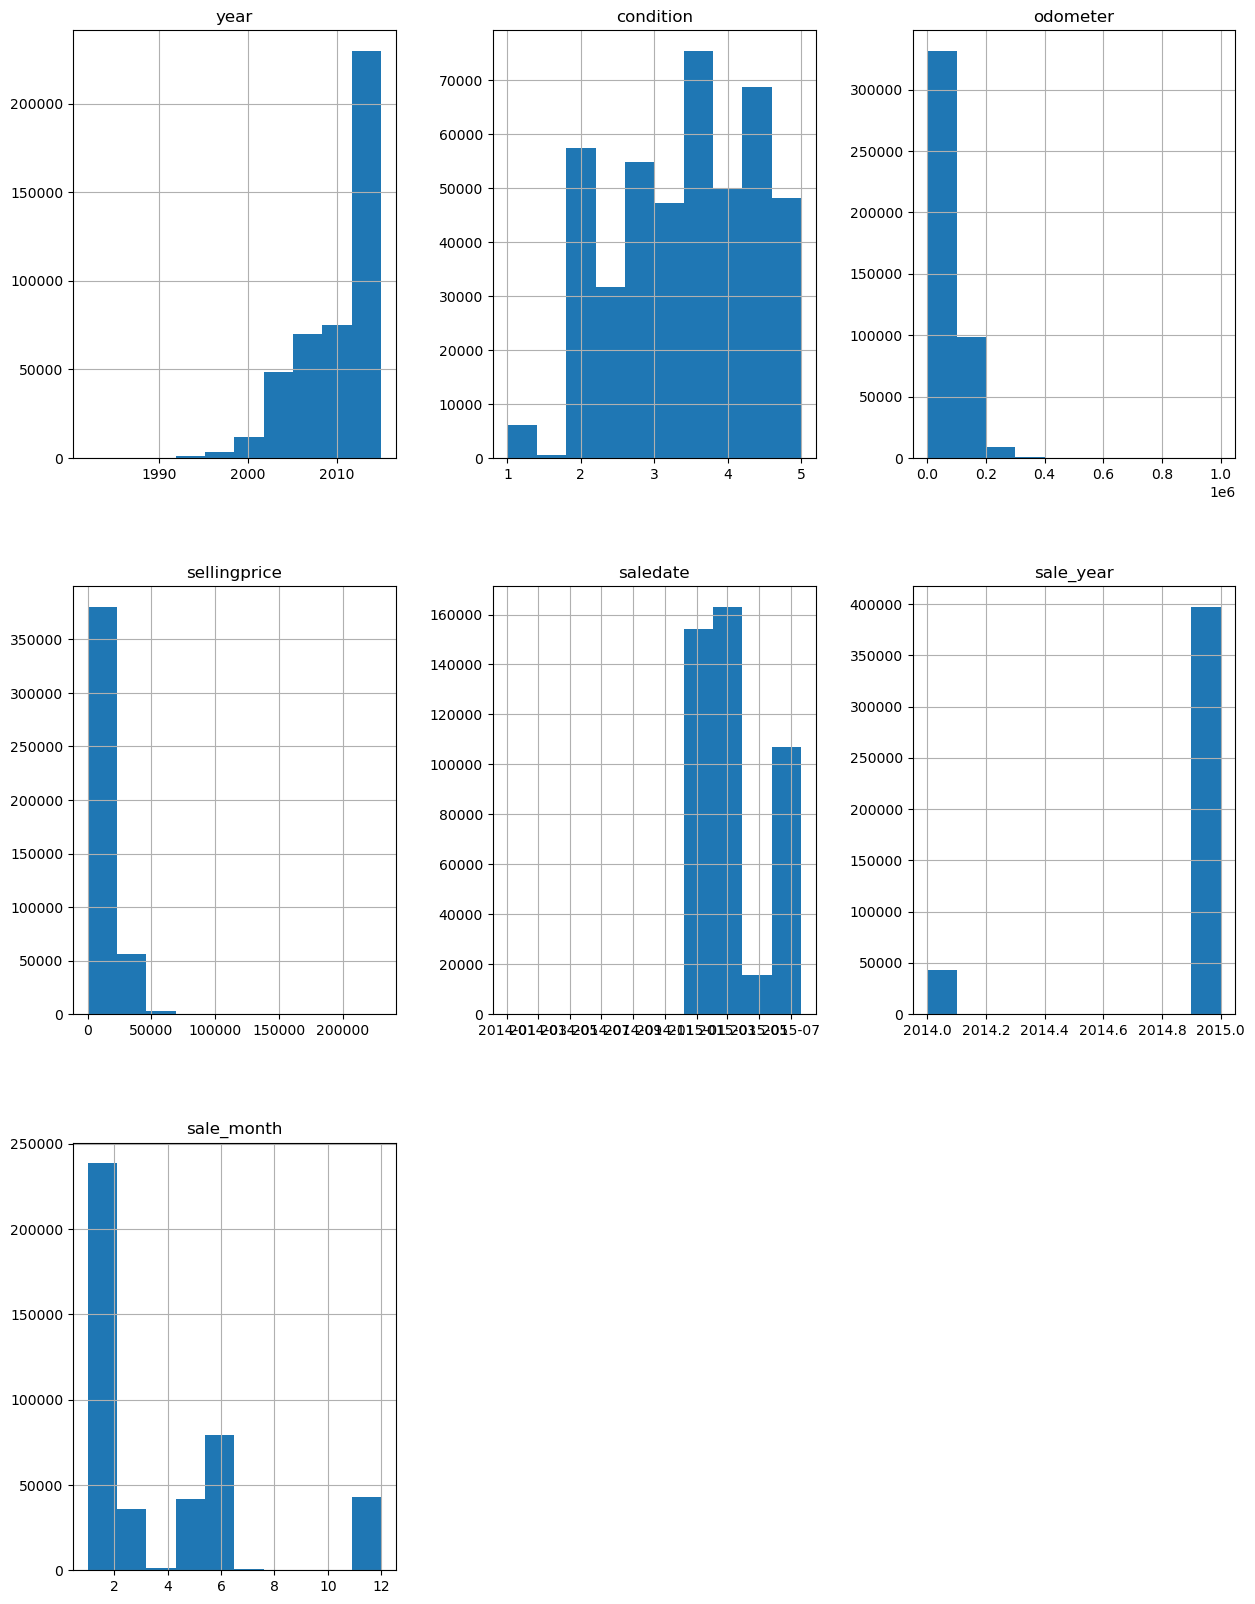

In [52]:
data_train.hist(figsize=(15, 20));

**Из гистграмм видно, что в продаже в основном автомобили не старше пяти лет, хотя встречаются и довольно старые автомобили; автомобили в разном состоянии, но откровенно плохих мало; автомобили в основном с пробегом до 60 тыс. миль, но встречаются и автомобили с очень большим пробегом; стоимость автомобилей в основном до 25 тыс. долларов, но встречаются и довольно дорогие экземпляры. Такой разброс вполне объясним, поэтому выбросы удалять не будем.**

### Исследование и предобработка тестового датасета. 

**Исследование предобработку тестового датасета произведём точно так же как и тренировочного датасета, за исключением отсутствующего столбца `sellingprice`.**

In [53]:
data_test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


In [54]:
data_test.shape

(110058, 14)

In [55]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


In [56]:
data_test.describe()

,year,condition,odometer
count,110058.000000,107679.000000,110039.000000
mean,2010.060005,3.423222,68074.331601
std,3.960190,0.951301,53520.988173
min,1982.000000,1.000000,1.000000
25%,2007.000000,2.700000,28313.500000
50%,2012.000000,3.600000,51922.000000
75%,2013.000000,4.200000,98852.500000
max,2015.000000,5.000000,999999.000000


In [57]:
data_test.duplicated().sum()

0

In [58]:
data_test.isnull().sum()

year                0
make             2061
model            2079
trim             2114
body             2594
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
dtype: int64

In [59]:
data_test['saledate'] = data_test['saledate'].apply(lambda x: datetime.datetime.strptime(x[:-15], "%a %b %d %Y %H:%M:%S"))

In [60]:
data_test['sale_year'] = pd.DatetimeIndex(data_test['saledate']).year
data_test['sale_year'].unique()

array([2015, 2014], dtype=int64)

In [61]:
data_test['sale_month'] = pd.DatetimeIndex(data_test['saledate']).month
data_test['sale_month'].unique()

array([ 1,  2,  3,  6, 12,  7,  5,  4], dtype=int64)

In [62]:
data_test.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,sale_year,sale_month
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015-01-14 04:30:00,2015,1
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,2015-02-27 01:00:00,2015,2
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2015-02-24 01:30:00,2015,2
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,2015-03-06 02:00:00,2015,3
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,2015-06-03 03:30:00,2015,6


In [63]:
data_test['make'].unique()

array(['Cadillac', 'GMC', 'Nissan', 'Chevrolet', 'Volkswagen', 'Hyundai',
       'Ford', 'Infiniti', 'Subaru', 'Kia', 'BMW', nan, 'Mitsubishi',
       'Dodge', 'Oldsmobile', 'Volvo', 'Pontiac', 'Acura', 'Honda',
       'Toyota', 'Audi', 'Jeep', 'Lincoln', 'Chrysler', 'Mercedes-Benz',
       'Ram', 'Scion', 'Mercury', 'Lexus', 'Saturn', 'Mazda', 'Porsche',
       'MINI', 'smart', 'Buick', 'HUMMER', 'ford', 'chrysler', 'Jaguar',
       'mitsubishi', 'FIAT', 'Saab', 'mazda', 'Suzuki', 'Land Rover',
       'bmw', 'cadillac', 'oldsmobile', 'honda', 'acura', 'buick',
       'landrover', 'Geo', 'lexus', 'dodge', 'chevrolet', 'chev truck',
       'nissan', 'Bentley', 'jeep', 'mercury', 'toyota', 'gmc', 'Isuzu',
       'Aston Martin', 'Maserati', 'land rover', 'kia', 'subaru',
       'Daewoo', 'vw', 'volkswagen', 'Tesla', 'mercedes', 'Ferrari',
       'hyundai', 'pontiac', 'Fisker', 'porsche', 'Rolls-Royce', 'Lotus',
       'Plymouth', 'hyundai tk', 'lincoln', 'ford tk', 'audi'],
      dtype=ob

In [64]:
data_test = data_test.replace({ 'bmw': 'BMW',
                                 'smart': 'Smart',
                                 'oldsmobile': 'Oldsmobile',
                                 'ford': 'Ford',
                                 'ford tk': 'Ford',
                                 'chrysler': 'Chrysler',
                                 'mazda': 'Mazda',
                                 'dodge': 'Dodge',
                                 'hyundai': 'Hyundai',
                                 'hyundai tk': 'Hyundai',
                                 'pontiac': 'Pontiac',
                                 'subaru': 'Subaru',
                                 'toyota': 'Toyota',
                                 'lincoln': 'Lincoln',
                                 'nissan': 'Nissan',
                                 'chevrolet': 'Chevrolet',
                                 'chev truck': 'Chevrolet',
                                 'honda': 'Honda',
                                 'porsche': 'Porsche',
                                 'mitsubishi': 'Mitsubishi',
                                 'lexus': 'Lexus',
                                 'acura': 'Acura',
                                 'jeep': 'Jeep',
                                 'mercury': 'Mercury',
                                 'landrover': 'Land Rover',
                                 'land rover': 'Land Rover',
                                 'vw': 'Volkswagen',
                                 'volkswagen': 'Volkswagen',
                                 'audi': 'Audi',
                                 'gmc': 'GMC',
                                 'kia': 'Kia',
                                 'mercedes': 'Mercedes-Benz',
                                 'cadillac': 'Cadillac',
                                 'buick': 'Buick'
})

In [65]:
data_test['make'].unique()

array(['Cadillac', 'GMC', 'Nissan', 'Chevrolet', 'Volkswagen', 'Hyundai',
       'Ford', 'Infiniti', 'Subaru', 'Kia', 'BMW', nan, 'Mitsubishi',
       'Dodge', 'Oldsmobile', 'Volvo', 'Pontiac', 'Acura', 'Honda',
       'Toyota', 'Audi', 'Jeep', 'Lincoln', 'Chrysler', 'Mercedes-Benz',
       'Ram', 'Scion', 'Mercury', 'Lexus', 'Saturn', 'Mazda', 'Porsche',
       'MINI', 'Smart', 'Buick', 'HUMMER', 'Jaguar', 'FIAT', 'Saab',
       'Suzuki', 'Land Rover', 'Geo', 'Bentley', 'Isuzu', 'Aston Martin',
       'Maserati', 'Daewoo', 'Tesla', 'Ferrari', 'Fisker', 'Rolls-Royce',
       'Lotus', 'Plymouth'], dtype=object)

In [66]:
data_test['make'].value_counts()

Ford             18466
Chevrolet        11802
Nissan           10485
Toyota            7728
Dodge             6188
Honda             5382
Hyundai           4410
BMW               4136
Kia               3571
Mercedes-Benz     3471
Chrysler          3459
Jeep              3069
Infiniti          3002
Volkswagen        2515
Lexus             2430
GMC               2059
Mazda             1676
Cadillac          1496
Lincoln           1153
Acura             1151
Audi              1124
Buick             1019
Subaru            1015
Ram                889
Pontiac            866
Mitsubishi         806
Volvo              765
MINI               674
Saturn             544
Mercury            434
Land Rover         371
Scion              318
Jaguar             297
Porsche            280
Suzuki             222
FIAT               181
HUMMER             174
Saab                93
Oldsmobile          88
Smart               81
Isuzu               38
Bentley             23
Maserati            21
Tesla      

In [67]:
data_test['make'].unique()

array(['Cadillac', 'GMC', 'Nissan', 'Chevrolet', 'Volkswagen', 'Hyundai',
       'Ford', 'Infiniti', 'Subaru', 'Kia', 'BMW', nan, 'Mitsubishi',
       'Dodge', 'Oldsmobile', 'Volvo', 'Pontiac', 'Acura', 'Honda',
       'Toyota', 'Audi', 'Jeep', 'Lincoln', 'Chrysler', 'Mercedes-Benz',
       'Ram', 'Scion', 'Mercury', 'Lexus', 'Saturn', 'Mazda', 'Porsche',
       'MINI', 'Smart', 'Buick', 'HUMMER', 'Jaguar', 'FIAT', 'Saab',
       'Suzuki', 'Land Rover', 'Geo', 'Bentley', 'Isuzu', 'Aston Martin',
       'Maserati', 'Daewoo', 'Tesla', 'Ferrari', 'Fisker', 'Rolls-Royce',
       'Lotus', 'Plymouth'], dtype=object)

In [68]:
data_test['model'].unique()

array(['CTS', 'Savana Cargo', 'Murano', 'Impala', 'Titan', 'Passat',
       'Sonata', 'Explorer', 'G Sedan', 'Suburban', 'Forester', 'Escape',
       'Fiesta', 'Taurus', 'Forte', '6 Series', 'TrailBlazer',
       'Silverado 1500', 'Genesis', 'Equinox', nan, 'Lancer',
       'E-Series Wagon', 'Grand Caravan', 'Focus', 'Alero', 'XC60',
       'Montana', 'Fusion', 'Soul', 'TSX', 'G6', 'Accord', 'Maxima',
       'Camry', 'Sierra 1500', 'A6', 'Camaro', 'RAV4', 'Corolla', 'XC70',
       'Compass', 'Expedition', 'Jetta', 'CR-V', 'LS', 'Odyssey',
       'Transit Connect', 'Optima', 'Traverse', 'F-150', 'Elantra',
       'Altima', 'S6', 'Sorento', 'G35', 'M', 'FJ Cruiser',
       'Town and Country', 'Civic', 'C-Class', 'Avenger', '1500', 'FR-S',
       'X3', '300', 'Magnum', 'F-350 Super Duty', 'STS', 'G Coupe',
       'Terrain', 'Spectra', 'Cruze', 'Journey', 'Tucson', 'Tundra',
       'Malibu', 'Grand Cherokee', 'Grand Marquis', 'Sedona', 'RX 350',
       'A4', 'LS 460', '3 Series', 'X5', 'Ya

In [69]:
data_test['model'].value_counts()

Altima                    3736
F-150                     2737
Fusion                    2553
Camry                     2423
Escape                    2292
                          ... 
B-Class Electric Drive       1
bronco                       1
X4                           1
vibe                         1
Caprice                      1
Name: model, Length: 824, dtype: int64

In [70]:
data_train_filled = fill_missing_make_model(data_test)

100%|█████████████████████████████████████████████████████████████████████████| 110058/110058 [01:50<00:00, 994.83it/s]


In [71]:
data_test.isnull().sum()

year                0
make               47
model              47
trim             2114
body             2594
transmission    13011
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
sale_year           0
sale_month          0
dtype: int64

In [72]:
data_test['make'] = data_test['make'].fillna('unknown')

In [73]:
data_test['model'] = data_test['model'].fillna('unknown')

In [74]:
data_test['body'].unique()

array(['Sedan', 'Van', 'SUV', 'Crew Cab', 'wagon', 'G Sedan', 'Hatchback',
       'sedan', 'Convertible', 'crew cab', nan, 'van', 'Minivan', 'Wagon',
       'Coupe', 'suv', 'supercrew', 'minivan', 'SuperCrew', 'quad cab',
       'g coupe', 'CrewMax Cab', 'Regular Cab', 'G37 Coupe', 'hatchback',
       'Quad Cab', 'regular cab', 'coupe', 'E-Series Van', 'Extended Cab',
       'supercab', 'e-series van', 'Access Cab', 'G Coupe', 'convertible',
       'Double Cab', 'extended cab', 'SuperCab', 'king cab', 'g sedan',
       'CTS Coupe', 'genesis coupe', 'Beetle Convertible', 'access cab',
       'Promaster Cargo Van', 'crewmax cab', 'G Convertible', 'Mega Cab',
       'koup', 'Elantra Coupe', 'Koup', 'Q60 Convertible',
       'g convertible', 'Q60 Coupe', 'double cab', 'Club Cab', 'King Cab',
       'CTS-V Coupe', 'Xtracab', 'Genesis Coupe', 'tsx sport wagon',
       'club cab', 'mega cab', 'cts coupe', 'elantra coupe',
       'cts-v coupe', 'granturismo convertible', 'Cab Plus',
       'TS

In [75]:
data_test = data_test.replace({'suv': 'SUV',
                                 'sedan': 'Sedan',
                                 'g sedan': 'G Sedan',
                                 'wagon': 'Wagon',
                                 'minivan': 'Minivan',
                                 'hatchback': 'Hatchback',
                                 'coupe': 'Coupe',
                                 'regular cab': 'Regular Cab',
                                 'regular-cab': 'Regular Cab',
                                 'e-series van': 'E-Series Van',
                                 'supercrew': 'SuperCrew',
                                 'supercab': 'SuperCab',
                                 'tsx sport wagon': 'TSX Sport Wagon',
                                 'extended cab': 'Extended Cab',
                                 'double cab': 'Double Cab',
                                 'koup': 'Koup',
                                 'access cab': 'Access Cab',
                                 'crew cab': 'Crew Cab',
                                 'crewmax cab': 'CrewMax Cab',
                                 'quad cab': 'Quad Cab',
                                 'g coupe': 'G Coupe',
                                 'g convertible': 'G Convertible',
                                 'van': 'Van',
                                 'promaster cargo van': 'Promaster Cargo Van',
                                 'transit van': 'Transit Van',
                                 'club cab': 'Club Cab',
                                 'cts coupe': 'CTS Coupe',
                                 'cts-v coupe': 'CTS-V Coupe',
                                 'genesis coupe': 'Genesis Coupe',
                                 'q60 coupe': 'Q60 Coupe',
                                 'q60 convertible': 'Q60 Convertible',
                                 'mega cab': 'Mega Cab',
                                 'king cab': 'King Cab',
                                 'elantra coupe': 'Elantra Coupe',
                                 'beetle convertible': 'Beetle Convertible',
                                 'g37 coupe': 'G37 Coupe',
                                 'g37 convertible': 'G37 Convertible',
                                 'granturismo convertible': 'GranTurismo Convertible',
                                 'cab plus 4': 'Cab Plus 4',
                                 'xtracab': 'Xtracab',
                                 'convertible': 'Convertible'
})

In [76]:
data_test['body'] = data_test['body'].fillna('unknown')

In [77]:
data_test['trim'].unique()

array(['Base', '2500', 'S', ..., 'Hybrid w/Technology Package',
       'V6 Luxury Sport', 'awd xs ll bean'], dtype=object)

In [78]:
data_test['trim'] = data_test['trim'].fillna('unknown')

In [79]:
data_test['transmission'].unique()

array(['automatic', nan, 'manual'], dtype=object)

In [80]:
data_test['transmission'].value_counts()

automatic    93584
manual        3463
Name: transmission, dtype: int64

In [81]:
data_test['transmission'] = data_test['transmission'].fillna('automatic')

In [82]:
data_test['condition'].unique()

array([2.7, 4.4, 4.6, 2.3, 2.9, 2.4, 3.7, 3.2, 3.5, 3.4, 4.7, 5. , 1. ,
       3.9, 1.9, 2.6, 4.9, 3.3, 2. , 4.2, 4.5, 4.1, 4.8, 3.6, 3.1, 4.3,
       nan, 4. , 3. , 2.2, 3.8, 2.5, 2.1, 2.8, 1.7, 1.8, 1.6, 1.2, 1.4,
       1.1, 1.3, 1.5])

In [83]:
data_test['condition'].value_counts()

1.9    8429
3.5    5233
4.4    5096
3.7    5066
4.3    4832
4.2    4631
3.6    4574
4.1    4552
2.0    4117
3.9    3995
4.0    3921
2.8    3864
2.9    3810
3.8    3669
3.4    3422
2.7    3235
4.9    2626
4.6    2557
4.8    2521
4.5    2463
2.5    2444
2.6    2290
5.0    2218
3.0    2194
4.7    2152
3.3    1976
3.2    1919
3.1    1791
2.1    1782
2.4    1780
2.3    1603
1.0    1468
2.2    1199
1.8      69
1.6      43
1.7      42
1.4      29
1.2      21
1.5      20
1.1      13
1.3      13
Name: condition, dtype: int64

In [84]:
mean_by_year_test_con = data_test.groupby(data_test['year'])['condition'].mean()

data_test['condition'] = data_test.apply(lambda row: mean_by_year_test_con[row['year']] if pd.isnull(row['condition']) else row['condition'], axis=1)

In [85]:
data_test['odometer'].unique()

array([116970.,   6286.,  11831., ...,  99488.,  66085., 124036.])

In [86]:
data_test['odometer'].value_counts()

1.0         246
999999.0     17
14452.0       8
48473.0       8
40126.0       7
           ... 
1729.0        1
46226.0       1
37683.0       1
138097.0      1
124036.0      1
Name: odometer, Length: 77205, dtype: int64

In [87]:
mean_by_year_test_odo = data_test.groupby(data_test['year'])['odometer'].mean()

data_test['odometer'] = data_test.apply(lambda row: mean_by_year_test_odo[row['year']] if pd.isnull(row['odometer']) else row['odometer'], axis=1)

In [88]:
data_test['color'].unique()

array(['silver', 'white', 'gray', 'black', 'blue', 'red', 'burgundy',
       'off-white', 'gold', 'green', 'orange', 'charcoal', 'brown', '—',
       'beige', 'yellow', 'purple', nan, 'turquoise', 'pink', 'lime'],
      dtype=object)

In [89]:
data_test['color'].value_counts()

black        22006
white        20928
silver       16360
gray         16348
blue         10180
red           8384
—             4948
green         2270
gold          2207
beige         1826
burgundy      1759
brown         1300
orange         407
purple         284
off-white      275
yellow         274
charcoal        84
turquoise       49
pink            10
lime             1
Name: color, dtype: int64

In [90]:
data_test['color'] = data_test['color'].fillna('—')

In [91]:
data_test['interior'].unique()

array(['black', 'gray', 'beige', 'tan', '—', 'brown', 'red', 'silver',
       nan, 'blue', 'purple', 'off-white', 'green', 'orange', 'gold',
       'burgundy', 'white', 'yellow'], dtype=object)

In [92]:
data_test['interior'].value_counts()

black        48176
gray         34984
beige        11931
tan           8658
—             3380
brown         1664
red            264
blue           241
silver         225
off-white      107
gold            64
purple          58
green           44
burgundy        34
orange          33
white           33
yellow           4
Name: interior, dtype: int64

In [93]:
data_test['interior'] = data_test['interior'].fillna('—')

In [94]:
data_test.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
saledate        0
sale_year       0
sale_month      0
dtype: int64

**Все столбцы исследовали и заполнили пропуски.**

### Изучаем коэффициент корреляции целевого признака с остальными признаками.

In [95]:
data_train.corr()[['sellingprice']].sort_values('sellingprice', ascending=False)

,sellingprice
sellingprice,1.000000
year,0.586847
condition,0.544253
sale_year,0.077356
sale_month,-0.031276
odometer,-0.583120


**На стоимость автомобиля очень сильно влияют возраст автомобиля, состояние автомобиля и пробег автомобиля.**

### Кодирование категориальных признаков.

**Категориальные признаки закодируем методом TargetEncoder**

In [96]:
cat_columns = ['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'color', 'interior', 'seller']

In [97]:
target_enc = ce.TargetEncoder(cols=cat_columns)

In [98]:
target_enc.fit(data_train[cat_columns], data_train['sellingprice'])

TargetEncoder(cols=['make', 'model', 'trim', 'body', 'transmission', 'vin',
                    'state', 'color', 'interior', 'seller'])

In [99]:
train_TE = data_train.join(target_enc.transform(data_train[cat_columns]).add_suffix('_target'))

In [100]:
pd.set_option('display.max_columns', None)

**После кодирования удаляем столбцы с категориальными признаками и смотрим корреляцию**

In [101]:
train_TE = train_TE.drop(cat_columns, axis=1)

In [102]:
train_TE.corr()[['sellingprice']].sort_values('sellingprice', ascending=False)

,sellingprice
sellingprice,1.000000
seller_target,0.687373
model_target,0.679077
trim_target,0.642945
year,0.586847
condition,0.544253
make_target,0.451166
body_target,0.328735
interior_target,0.243423
state_target,0.225171


**На стоимость автомобиля, больше всего влияют марка, модель, комплектация, возраст, состояние и пробег автомобиля. Все признаки кроме `vin` оставим для обучения модели.**

In [103]:
train_TE

,year,condition,odometer,sellingprice,saledate,sale_year,sale_month,make_target,model_target,trim_target,body_target,transmission_target,vin_target,state_target,color_target,interior_target,seller_target
0,2011,4.2,111041.0,12500,2015-06-02 02:30:00,2015,6,14330.130335,18750.455222,14299.992376,16101.931946,13672.010846,13592.209588,7448.989614,15499.045687,15680.215374,7904.449305
1,2014,3.5,31034.0,14500,2015-02-25 02:00:00,2015,2,14330.130335,12366.645360,11220.154882,11715.115204,13672.010846,13592.209588,14462.472499,15499.045687,15680.215374,18164.501134
2,2012,2.2,35619.0,9100,2015-06-10 02:30:00,2015,6,11705.846100,8743.003000,8537.994012,11715.115204,13672.010846,13592.209588,13629.736268,15499.045687,15680.215374,13808.318524
3,2003,2.8,131301.0,13300,2015-06-17 03:00:00,2015,6,15284.787980,18475.112108,13824.966342,16101.931946,13672.010846,13592.209588,13159.645441,8302.543989,13341.925637,16458.695652
4,2007,2.0,127709.0,1300,2015-02-03 04:00:00,2015,2,14330.130335,12366.645360,14299.992376,11715.115204,13672.010846,13592.209588,7448.989614,15499.045687,15680.215374,904.778831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440231,2013,4.5,20434.0,16000,2015-01-20 04:30:00,2015,1,11834.390047,13415.362751,17144.871795,11715.115204,13672.010846,13592.209588,14543.383612,14718.716693,13341.925637,16091.026360
440232,2014,2.9,14675.0,24250,2015-02-11 02:00:00,2015,2,12347.068338,19104.089710,20650.000000,10106.121746,13672.010846,13592.209588,13872.295449,14718.716693,15680.215374,14167.141009
440233,2008,3.7,102552.0,16750,2015-03-03 04:30:00,2015,3,21840.049720,33290.256654,36335.047753,15791.662133,13672.010846,13592.209588,14543.383612,13931.332654,15680.215374,13592.209588
440234,2014,3.0,29367.0,33000,2015-01-14 02:05:00,2015,1,25234.263641,30745.254777,15282.679122,21569.694611,13672.010846,13592.209588,13159.645441,14718.716693,11002.863259,33302.906977


**Также кодируем и тестовый датафрейм**

In [104]:
test_TE = data_test.join(target_enc.transform(data_test[cat_columns]).add_suffix('_target'))

In [105]:
test_TE = test_TE.drop(cat_columns, axis=1)

In [106]:
test_TE

,year,condition,odometer,saledate,sale_year,sale_month,make_target,model_target,trim_target,body_target,transmission_target,vin_target,state_target,color_target,interior_target,seller_target
0,2005,2.7,116970.0,2015-01-14 04:30:00,2015,1,14960.647280,10603.919127,13824.966342,11715.115204,13672.010846,13592.209588,14543.383612,11762.329907,15680.215374,11514.453125
1,2014,4.4,6286.0,2015-02-27 01:00:00,2015,2,16765.228261,19510.273973,15471.360759,13794.867381,13672.010846,13592.209588,15942.628868,14718.716693,11002.863259,19843.157583
2,2013,4.6,11831.0,2015-02-24 01:30:00,2015,2,11705.846100,13032.931236,12542.081408,16101.931946,13672.010846,13592.209588,14421.217996,13931.332654,15680.215374,13808.318524
3,2013,2.3,57105.0,2015-03-06 02:00:00,2015,3,11787.176014,7944.597903,9822.020163,11715.115204,13672.010846,13592.209588,13836.098647,11762.329907,15680.215374,9451.948052
4,2013,2.9,31083.0,2015-06-03 03:30:00,2015,6,11705.846100,13229.944000,15259.274029,21569.694611,13672.010846,13592.209588,16975.481679,15499.045687,15680.215374,22213.175775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110053,2011,3.8,66085.0,2015-01-15 03:30:00,2015,1,14720.982311,21666.634398,12423.209800,16101.931946,13672.010846,13592.209588,14543.383612,12575.836096,15680.215374,10982.548261
110054,2014,4.8,17588.0,2015-06-15 11:00:00,2015,6,19902.431638,19190.191147,13824.966342,11715.115204,13672.010846,13592.209588,13836.098647,13931.332654,15680.215374,25786.529680
110055,2004,2.9,124036.0,2015-02-05 01:35:00,2015,2,11705.846100,13072.888611,6872.857143,11715.115204,13672.010846,13592.209588,8608.980623,11762.329907,11002.863259,10362.281977
110056,2013,2.2,27169.0,2015-06-17 03:30:00,2015,6,11705.846100,15704.181185,13824.966342,15791.662133,11110.293860,13592.209588,13159.645441,17926.340296,15680.215374,13051.650672


**Делим тренировочный датасет на тренировочную и тестовую выборки и подбираем гиперпараметры с помощью кроссвалидации.**

In [107]:
train, test = train_test_split(train_TE,train_size=0.8,random_state=42)

In [108]:
X = ['year', 'make_target', 'model_target', 'trim_target', 'body_target', 'transmission_target',
       'state_target', 'condition', 'odometer', 'color_target', 'interior_target', 'seller_target', 'sale_year', 'sale_month']

y = ['sellingprice']

In [109]:
train_data = Pool(data=train[X],
                  label=train[y]
                 )

In [110]:
test_data = Pool(data=test[X],
                  label=test[y]
                 )

In [111]:
params = {'iterations': 1000,
          'eval_metric': 'MAPE',
          'loss_function': 'RMSE',
              'learning_rate': 0.2,
              'random_seed': 42,
              'verbose':100}

In [112]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False,
    early_stopping_rounds=200
)

Training on fold [0/5]

bestTest = 0.2616178068
bestIteration = 749

Training on fold [1/5]

bestTest = 0.1583978605
bestIteration = 998

Training on fold [2/5]

bestTest = 0.1588039411
bestIteration = 999

Training on fold [3/5]

bestTest = 0.1658545099
bestIteration = 991

Training on fold [4/5]

bestTest = 0.1559459463
bestIteration = 999



In [113]:
cv_data.head()

,iterations,test-MAPE-mean,test-MAPE-std,train-MAPE-mean,train-MAPE-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,0.772470,0.011954,0.772206,0.003409,13734.224211,51.963547,13733.981640,15.103189
1,1,0.643658,0.026365,0.642856,0.005193,11388.431506,48.646429,11382.812358,13.796585
2,2,0.564745,0.033685,0.563470,0.005756,9543.036318,43.647028,9540.025591,17.216090
3,3,0.511150,0.039119,0.514440,0.009018,8108.263706,43.076381,8107.280295,15.666721
4,4,0.473011,0.050921,0.471714,0.009003,7004.932898,44.781957,7003.343531,20.386416


In [114]:
cv_data[cv_data['test-MAPE-mean'] == cv_data['test-MAPE-mean'].min()]

,iterations,test-MAPE-mean,test-MAPE-std,train-MAPE-mean,train-MAPE-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
991,991,0.180502,0.04638,0.17669,0.009803,1908.400252,50.665108,1730.411205,13.118179


In [115]:
n_iters = cv_data[cv_data['test-MAPE-mean'] == cv_data['test-MAPE-mean'].min()]['iterations'].values[0]
n_iters

991

**Провели обучение и сравнение моделей Случайный лес, Дерево решений, Линейная регрессия и CatBoostRegressor. Наименьший MAPE показал CatBoostRegressor, поэтому остальные модели из проекта удалили.**

In [116]:
params = {'iterations': 1000,
          'eval_metric': 'MAPE',
          'loss_function': 'RMSE',
          'learning_rate': 0.2,
          'random_seed': 42,
          'verbose':100}

In [117]:
model = CatBoostRegressor(**params)

In [118]:
model.fit(train_data)

0:	learn: 1.6087591	total: 34.9ms	remaining: 34.8s
100:	learn: 0.2539871	total: 3.05s	remaining: 27.1s
200:	learn: 0.2268765	total: 5.99s	remaining: 23.8s
300:	learn: 0.2146431	total: 8.93s	remaining: 20.7s
400:	learn: 0.2062379	total: 11.9s	remaining: 17.7s
500:	learn: 0.1971599	total: 14.8s	remaining: 14.7s
600:	learn: 0.1924918	total: 17.7s	remaining: 11.8s
700:	learn: 0.1893426	total: 20.7s	remaining: 8.82s
800:	learn: 0.1856517	total: 23.6s	remaining: 5.86s
900:	learn: 0.1828155	total: 26.6s	remaining: 2.92s
999:	learn: 0.1799700	total: 29.5s	remaining: 0us


In [119]:
test['y_pred'] = model.predict(test_data)

In [120]:
mean_absolute_percentage_error(test['sellingprice'],test['y_pred'])

0.15943309481678736

**Модель обучена, MAPE - 0.16099**

**Подготавливаем тестовый датафрейм и получаем предсказания.**

In [121]:
X_test = test_TE[['year', 'make_target', 'model_target', 'trim_target', 'body_target', 'transmission_target',
       'state_target', 'condition', 'odometer', 'color_target', 'interior_target', 'seller_target', 'sale_year', 'sale_month']]

In [122]:
X_test

,year,make_target,model_target,trim_target,body_target,transmission_target,state_target,condition,odometer,color_target,interior_target,seller_target,sale_year,sale_month
0,2005,14960.647280,10603.919127,13824.966342,11715.115204,13672.010846,14543.383612,2.7,116970.0,11762.329907,15680.215374,11514.453125,2015,1
1,2014,16765.228261,19510.273973,15471.360759,13794.867381,13672.010846,15942.628868,4.4,6286.0,14718.716693,11002.863259,19843.157583,2015,2
2,2013,11705.846100,13032.931236,12542.081408,16101.931946,13672.010846,14421.217996,4.6,11831.0,13931.332654,15680.215374,13808.318524,2015,2
3,2013,11787.176014,7944.597903,9822.020163,11715.115204,13672.010846,13836.098647,2.3,57105.0,11762.329907,15680.215374,9451.948052,2015,3
4,2013,11705.846100,13229.944000,15259.274029,21569.694611,13672.010846,16975.481679,2.9,31083.0,15499.045687,15680.215374,22213.175775,2015,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110053,2011,14720.982311,21666.634398,12423.209800,16101.931946,13672.010846,14543.383612,3.8,66085.0,12575.836096,15680.215374,10982.548261,2015,1
110054,2014,19902.431638,19190.191147,13824.966342,11715.115204,13672.010846,13836.098647,4.8,17588.0,13931.332654,15680.215374,25786.529680,2015,6
110055,2004,11705.846100,13072.888611,6872.857143,11715.115204,13672.010846,8608.980623,2.9,124036.0,11762.329907,11002.863259,10362.281977,2015,2
110056,2013,11705.846100,15704.181185,13824.966342,15791.662133,11110.293860,13159.645441,2.2,27169.0,17926.340296,15680.215374,13051.650672,2015,6


In [123]:
predictions = model.predict(X_test)

In [124]:
data_test['sellingprice'] = predictions

In [125]:
data_test

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,sale_year,sale_month,sellingprice
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015-01-14 04:30:00,2015,1,4538.567130
1,2014,GMC,Savana Cargo,2500,Van,automatic,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,2015-02-27 01:00:00,2015,2,21844.963735
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2015-02-24 01:30:00,2015,2,20073.425853
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,2015-03-06 02:00:00,2015,3,8733.823992
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,2015-06-03 03:30:00,2015,6,22426.401213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110053,2011,Jeep,Wrangler,Sport,SUV,automatic,1j4aa2d17bl584330,ca,3.8,66085.0,orange,black,dtg operations inc,2015-01-15 03:30:00,2015,1,16925.542961
110054,2014,Lexus,IS 250,Base,Sedan,automatic,jthbf1d23e5007526,fl,4.8,17588.0,gray,black,lexus financial services,2015-06-15 11:00:00,2015,6,29033.660193
110055,2004,Nissan,Maxima,3.5 SL,Sedan,automatic,1n4ba41e54c831950,va,2.9,124036.0,silver,gray,shirlie slack mitsubishi,2015-02-05 01:35:00,2015,2,4182.551708
110056,2013,Nissan,370Z,Base,Coupe,manual,jn1az4eh3dm382431,tx,2.2,27169.0,—,black,nissan motor acceptance corporation,2015-06-17 03:30:00,2015,6,17342.069537


In [126]:
data_pred = data_test[['vin', 'sellingprice']]
data_pred

,vin,sellingprice
0,1g6dp567450124779,4538.567130
1,1gtw7fca7e1902207,21844.963735
2,jn8az1mw6dw303497,20073.425853
3,2g1wf5e34d1160703,8733.823992
4,1n6aa0ec3dn301209,22426.401213
...,...,...
110053,1j4aa2d17bl584330,16925.542961
110054,jthbf1d23e5007526,29033.660193
110055,1n4ba41e54c831950,4182.551708
110056,jn1az4eh3dm382431,17342.069537


In [127]:
data_pred['sellingprice'].min()

-4892.907364502225

**В итоговой таблице у нас имеются предсказания стоимости с отрицательным значением. Поэтому меняем эти значения на значение 0,05-го перцентиля.**

In [128]:
q = np.percentile(data_pred['sellingprice'], 1)
print(q)

524.0957800723237


In [129]:
data_pred.loc[data_pred['sellingprice'] < 524, 'sellingprice'] = 524

In [130]:
data_pred['sellingprice'].min()

524.0

In [131]:
data_pred.to_csv('pred.csv', index=False)

**Итоговая таблица готова.**

## Отчёт.

**Нам была поставлена цель проекта - разработка модели предварительной оценки стоимости автомобиля на вторичном рынке. Для её достижения нами были поставлены и выполнены следующие задачи:**
- загружены необходимые библиотеки и инструменты;
- загружены и изучены предоставленные датафреймы - тренировочный, на основе которого разрабатываем модель, и тестовый;
- произведена предварительная обработка данных: 
    - проверка на дубликаты, 
    - заполнение выявленных пропусков в данных, подобранным для каждого столбца способом;
- на основе предварительного анализа создали столбцы с новыми признаками;
- закодировали категориальные признаки;
- изучили корреляцию между признаками;
- провели отбор признаков для обучения модели;
- выбрали модели обучения;
- с помощью кроссвалидации на тренеровочном датафрейме подобрали гиперпараметры для выбранных моделей;
- обучили модели и выбрали лучшую модель по метрике MAPE - CatBoostRegressor;
- получили предсказание модели на предоставленном тестовом датафрейме.

**При предобработке данных были выявлены пропуски в некоторых столбцах. Возникли трудности с их заполнением. Но способы корректного заполнения этих пропусков были найдены. В столбце `make` - производитель, обнаружено 8043 пропусков, а также неявные дубликаты. Привели название марок к единому виду. В столбцах `make` и `model` большее колиство пропусков заполнили по первым знакам столбца vin в строках с пропусками, взятыми значениями из заполненных строк. Оставшиеся пропуски заполнили заглушкой "unknown". В столбце `body` - тип кузова, обнаружено 10393 пропусков, а также неявные дубликаты. Привели название типов кузовов к единому виду. Пропуски заполнили заглушкой "unknown". В столбце `trim` - модификация, обнаружено 8337 пропусков, а также неявные дубликаты. Пропуски заполнили заглушкой "unknown". В столбце `transmission` - тип КПП, обнаружено 51461 пропусков, а также неявные дубликаты. Так как абсолюьное большинство автомобилей имеют автоматическую коробку передач, то пропуски заполнили значением "automatic". В столбце `condition` - состояние по шкале (1-5), обнаружено 9405 пропусков. Использовал функцию, которая заполняет пропуски медианным значением в зависимости от года выпуска авто. В столбце `odometer` - пробег в милях, обнаружено 69 пропусков. Использовал функцию, которая заполняет пропуски медианным значением в зависимости от года выпуска авто. В столбце `color` - цвет кузова, обнаружено 586 пропусков. Заполнил пропуски значением "—". В столбце `interior` - цвет интерьера, обнаружено 586 пропусков. Заполнил пропуски значением "—". Добавили новые признаки - `sale_month` - месяц продажи и `sale_year` - год продажи, для этого привели столбец с датой столбец `saledate` с датой продажи к типу .daytime и извлекли из него месяц и год.**

**Для обучения были выбраны четыре модели - Случайный лес, Дерево решений, Линейная регрессия и CatBoostRegressor. Для подбора гиперпараметров применили кроссвалидацию. CatBoostRegressor оказалась наилучшей моделью, её MAPE оказалась самой низкой - 0.16099. Поэтому было решено выбрать её. Для улучшения результатов обучения модели предварительно закодировали категориальные признаки методом TargetEncoder. Для обучения модели были выбраны все признаки кроме `vin`, так как он имеет коэффициент корреляции 1, т.е. имеет мультиколлинеарность с целевым признаком.**

**После получения предсказания на тестовом датафрейме, увидели, что некоторое количество предсказанных значений стоимости автомобиля имеет отрицательное значение, хотя такого быть не может. Было решено заменить эти значения на значение 1-го перцентиля - 524 доллара.**

**По результатам проверки модели убедились, что модель является работоспособной и надёжной, имеет низкую MAPE и может применяться для предварительного расчёта стоимости автомобиля на вторичном рынке.**

**Для улучшения модели и её метрики качества можно проделать дополнительную работу по более корректному заполнению пропусков - найти и выделить новые признаки на основе более углублённого анализа данных. Также имеет смысл поработать с подбором большего количества гипермараметров. Кроме того необходимо раз в шесть месяцев проводить дообучение модели - брать данные о продажах на вторичном рынке за последние полгода, так как появляются новые модели, отсутствующие в старом датафрейме, а старые модели дешевеют, поэтому предсказания будут менее точны.**